# 👩‍⚕️ Classificador de Sintomas
### Aplicação: Classificação de sintomas em linguagem natural para sugerir especialidade médica

## 📚 Importação das bibliotecas

In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

nltk.download('stopwords')
stopwords_en = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 🧼 Caregamento e limpeza dos dados

In [2]:
df = pd.read_csv('/content/medquad.csv')
df.head(5)

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [3]:
# Assumindo que 'question' é o texto do sintoma e 'focus_area' é a especialidade
df_pares = pd.DataFrame({'texto_sintoma': df['question'], 'especialidade': df['focus_area']})

In [4]:
# Verificando se há valores nulos para retirar do dataset
df_pares.isnull().sum()

,0
texto_sintoma,0
especialidade,14


In [5]:
# Removendo valores NaN
df_pares_sem_nan = df_pares.dropna()
print(f"Shape antes de remover NaN: {df_pares.shape}")
print(f"Shape depois de remover NaN: {df_pares_sem_nan.shape}")

Shape antes de remover NaN: (16412, 2)
Shape depois de remover NaN: (16398, 2)


## ✂️ Pré-processamento do texto

In [6]:
# Verifica se precisa balancear as classes
counts = df_pares_sem_nan['especialidade'].value_counts()

counts.head(3)

,count
especialidade,
Breast Cancer,53
Prostate Cancer,43
Stroke,35


In [7]:
counts.tail(3)

,count
especialidade,
GOSR2-related progressive myoclonus ataxia,1
Familial episodic pain syndrome,1
"Coloboma, cleft lip/palate and mental retardation syndrome",1


In [8]:
# Agrupa especialidades muito raras
frequency = df_pares_sem_nan['especialidade'].value_counts()
rare = frequency[frequency < 7].index
mask_rare = df_pares_sem_nan['especialidade'].isin(rare)
df_pares_sem_nan.loc[mask_rare, 'especialidade'] = 'Other speciality'

<ipython-input-8-56d41594279a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pares_sem_nan.loc[mask_rare, 'especialidade'] = 'Other speciality'


In [9]:
def limpar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove pontuação
        tokens = texto.split()
        tokens = [token for token in tokens if token not in stopwords_en]   # Remoção de stopwords
        return ' '.join(tokens)
    return ''

df_pares_sem_nan['texto_sintoma_limpo'] = df_pares_sem_nan['texto_sintoma'].apply(limpar_texto)
print(df_pares_sem_nan[['texto_sintoma', 'texto_sintoma_limpo']].head())

                            texto_sintoma  texto_sintoma_limpo
0                What is (are) Glaucoma ?             glaucoma
1                  What causes Glaucoma ?      causes glaucoma
2     What are the symptoms of Glaucoma ?    symptoms glaucoma
3  What are the treatments for Glaucoma ?  treatments glaucoma
4                What is (are) Glaucoma ?             glaucoma


<ipython-input-9-12369db931b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pares_sem_nan['texto_sintoma_limpo'] = df_pares_sem_nan['texto_sintoma'].apply(limpar_texto)


## ⛏️ Dividir em features e rótulos

In [10]:
X = df_pares_sem_nan['texto_sintoma_limpo']
y = df_pares_sem_nan['especialidade']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 🔗 Amostragem (reduzindo para 100k exemplos)

In [11]:
amostra_size = min(100000, X_train.shape[0])

indices = np.random.choice(X_train.index, size=amostra_size, replace=False)
X_train_sample = X_train.loc[indices]
y_train_sample = y_train.loc[indices]

## 🔤 Tokenizer (com 50000 palavras mais frequentes)

In [12]:
num_words = 50000
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_sample)

X_train_seq = tokenizer.texts_to_sequences(X_train_sample)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

## 🖌️ Padding

In [13]:
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

## 🧩 Codificar rótulos

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_sample)

y_train_enc = label_encoder.transform(y_train_sample)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)

## 🌋 One-hot

In [15]:
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes)

## 🚧 Construção do modelo CNN e treinamento do modelo

In [16]:
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Treina o modelo
epochs = 30
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_pad, y_val_cat),
                    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.6941 - loss: 3.1115 - val_accuracy: 0.7285 - val_loss: 1.8158
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.7390 - loss: 1.6797 - val_accuracy: 0.7272 - val_loss: 1.7205
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 71s 90ms/step - accuracy: 0.7332 - loss: 1.6100 - val_accuracy: 0.7285 - val_loss: 1.6027
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.7417 - loss: 1.4595 - val_accuracy: 0.7362 - val_loss: 1.4786
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.7461 - loss: 1.3496 - val_accuracy: 0.7508 - val_loss: 1.3116
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.7577 - loss: 1.1872 - val_accuracy: 0.7671 - val_loss: 1.1163
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.7695 - loss: 1.0701 - val_accuracy: 0.8037 - val_loss: 0.9241
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.7891 - loss: 0.9194 -

In [17]:
loss, acc = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9656 - loss: 0.0982
Test Accuracy: 0.9683


## 👓 Visualização dos resultados

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

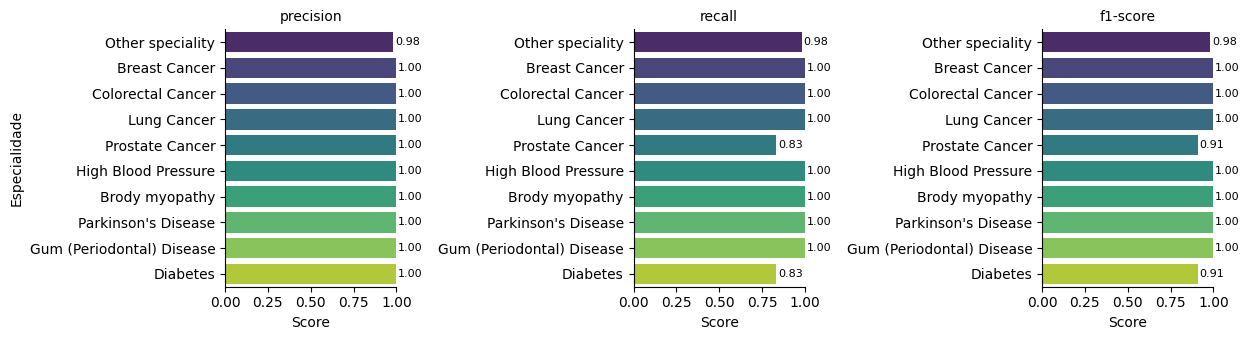

In [18]:
# Obtém labels verdadeiros e previstos já como strings
y_true = label_encoder.inverse_transform(y_test_cat.argmax(1))
y_pred = label_encoder.inverse_transform(model.predict(X_test_pad).argmax(1))

# Monta o DataFrame direto do report e já filtra as 10 classes mais comuns
df = (pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T.drop(['accuracy','macro avg','weighted avg'], errors='ignore'))
df['support'] = df['support'].astype(int)
df = df.sort_values('support', ascending=False).head(10).reset_index().rename(columns={'index':'class'})

df_melt = df.melt(
    id_vars=['class','support'],
    value_vars=['precision','recall','f1-score'],
    var_name='metric', value_name='score'
)

# Plota o FacetGrid
g = sns.FacetGrid(df_melt, col='metric', sharex=True, sharey=False, height=3.5, aspect=1.2)
g.map_dataframe(sns.barplot, x='score', y='class', palette='viridis')
g.set_titles('{col_name}')
g.set_axis_labels('Score','Especialidade')
for ax in g.axes.flat:
    ax.set_xlim(0,1)
    for p in ax.patches:
        ax.text(p.get_width()+0.01, p.get_y()+p.get_height()/2,
                f'{p.get_width():.2f}', va='center', fontsize=8)
plt.tight_layout()
plt.show()

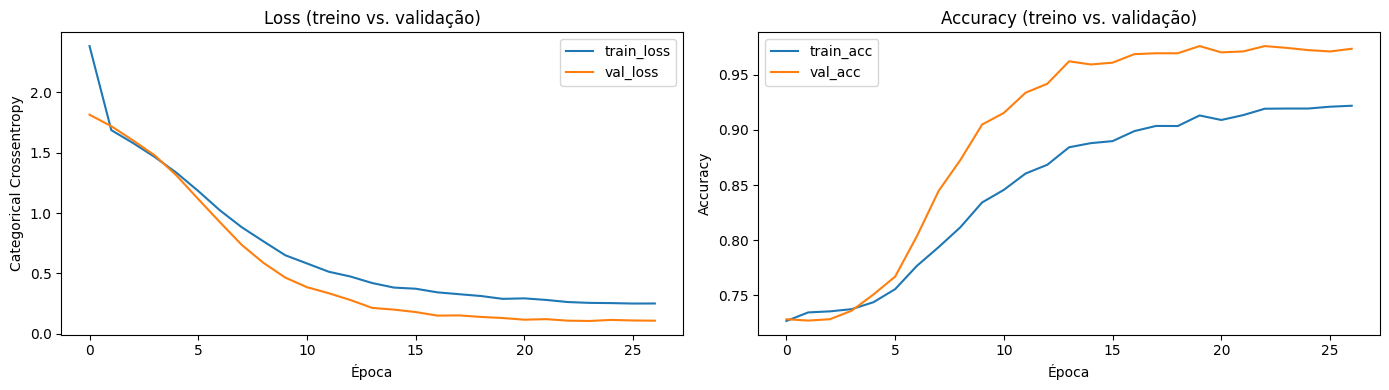

359/359 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
=== Relatório de Treino ===
                                                                                                                                          precision    recall  f1-score   support

                                                                                       17-beta hydroxysteroid dehydrogenase 3 deficiency       1.00      1.00      1.00         7
                                                                                            2-methylbutyryl-CoA dehydrogenase deficiency       1.00      1.00      1.00         4
                                                                                                               21-hydroxylase deficiency       1.00      1.00      1.00         8
                                                                                                               22q11.2 deletion syndrome       1.00      1.00      1.00         9

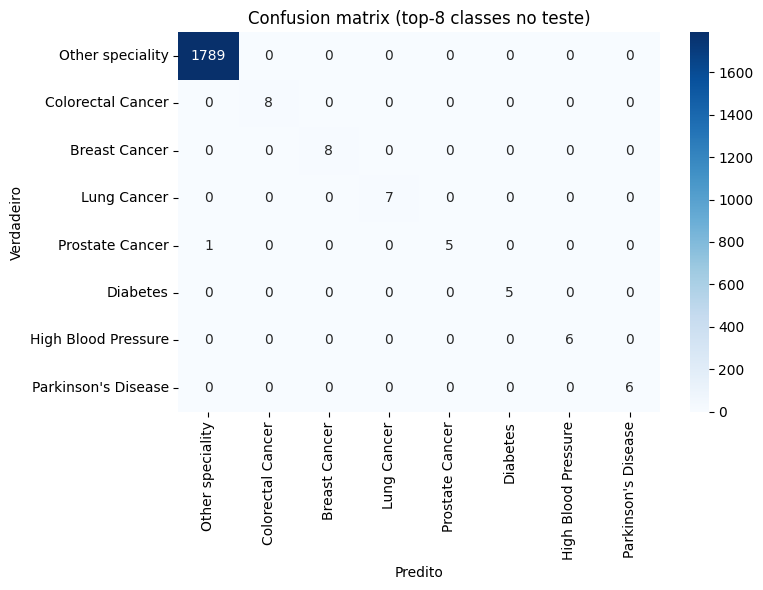

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
=== Relatório de Treino ===
                                                                                                                                          precision    recall  f1-score   support

                                                                                       17-beta hydroxysteroid dehydrogenase 3 deficiency       0.00      0.00      0.00         0
                                                                                            2-methylbutyryl-CoA dehydrogenase deficiency       0.00      0.00      0.00         0
                                                                                                               21-hydroxylase deficiency       0.00      0.00      0.00         0
                                                                                                               22q11.2 deletion syndrome       0.00      0.00      0.00         0
 

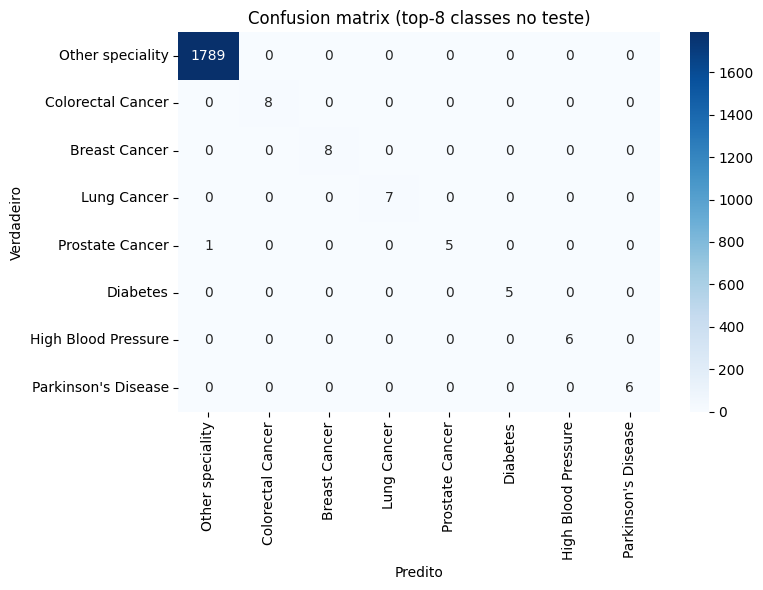

In [ ]:
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    axes[0].plot(history.history['loss'],  label='train_loss')
    axes[0].plot(history.history['val_loss'],  label='val_loss')
    axes[0].set_title('Loss (treino vs. validação)')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Categorical Crossentropy')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'],      label='train_acc')
    axes[1].plot(history.history['val_accuracy'], label='val_acc')
    axes[1].set_title('Accuracy (treino vs. validação)')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def evaluate_generalization(model, X_train, y_train_cat, X_test, y_test_cat, label_encoder=None):
    y_train_true = np.argmax(y_train_cat, axis=1)
    y_test_true  = np.argmax(y_test_cat,  axis=1)
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_test_pred  = np.argmax(model.predict(X_test),  axis=1)

    # Se tiver encoder, transforma de volta em nomes
    if label_encoder is not None:
        labels = label_encoder.classes_
        y_train_true = label_encoder.inverse_transform(y_train_true)
        y_train_pred = label_encoder.inverse_transform(y_train_pred)
        y_test_true  = label_encoder.inverse_transform(y_test_true)
        y_test_pred  = label_encoder.inverse_transform(y_test_pred)
    else:
        labels = None

    # Classification reports
    print("=== Relatório de Treino ===")
    print(classification_report(y_train_true, y_train_pred, labels=labels, zero_division=0))
    print("\n=== Relatório de Teste ===")
    print(classification_report(y_test_true,  y_test_pred,  labels=labels, zero_division=0))

    # Confusion matrix no teste
    cm = confusion_matrix(y_test_true, y_test_pred, labels=labels)
    if labels is not None:
        # Seleciona as 8 classes mais frequentes no teste
        support = pd.Series(y_test_true).value_counts().index[:8]
    else:
        support = np.arange(cm.shape[0])[:8]

    idx = [list(labels).index(c) for c in support] if labels is not None else support
    cm8 = cm[np.ix_(idx, idx)]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm8, annot=True, fmt='d',
                xticklabels=support, yticklabels=support,
                cmap='Blues')
    plt.title('Confusion matrix (top-8 classes no teste)')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.tight_layout()
    plt.show()


plot_training_curves(history)
evaluate_generalization(
    model,
    X_train_pad, y_train_cat,
    X_test_pad,  y_test_cat,
    label_encoder=label_encoder
)
evaluate_generalization(model, X_val_pad, y_val_cat, X_test_pad,  y_test_cat, label_encoder=label_encoder)

### 🪡 Validação do modelo

In [ ]:
def predizer_especialidade(prompt: str):
    txt = limpar_texto(prompt)
    print("Texto limpo:", txt)
    seq = tokenizer.texts_to_sequences([txt])
    pad = pad_sequences(seq, maxlen=maxlen, padding='post')

    probs = model.predict(pad)[0]
    top3 = np.argsort(probs)[-3:][::-1]

    print("\nTop-3 previsões:")
    for i in top3:
        cls = label_encoder.inverse_transform([i])[0]
        print(f"  • {cls:<25} {probs[i]:.2%}")
    print()
predizer_especialidade("painful blistering rash around the mouth")

# Exemplos de entrada:
# sharp abdominal cramps and nausea
# shortness of breath and wheezing at night
# painful blistering rash around the mouth

Texto limpo: painful blistering rash around mouth
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

Top-3 previsões:
  • Osteosarcoma and Malignant Fibrous Histiocytoma of Bone 58.22%
  • Chronic Diarrhea in Children 14.17%
  • Other speciality          8.83%

